In [1]:
import os
os.chdir('/home/victorhuang/projects/gtx/')
# os.chdir('/home/victorh/projects/gtx/')

import numpy as np
import mat73
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter
from skimage.filters import threshold_otsu

from numerical.op_props_util import *

In [2]:
# Spatial frequency
fx = [0, 0.05, 0.1, 0.15, 0.2, 0.25] 
fx = np.array(fx)

dt_data_path = 'data/20241118_data_splited.mat'
phantom_data_path = 'data/phantom_data.mat'
cylinder_data_path_r2 = 'data/cylinder/h5_r15_d3.mat'

In [3]:
def read_mat_data(path, mat=True):
    if mat:
        mat_data = mat73.loadmat(path)
        return {
            'fluorescence': mat_data['F'],
            'optical_props': mat_data['OP'],
            'depth': mat_data['DF'],
            'concentration_fluor': mat_data['QF'],
            'reflectance': mat_data['RE']
        }
    else:
        mat_data = sio.loadmat(path)
        data = {k: v for k, v in mat_data.items() if not k.startswith('__')}

        splits = ['train', 'val', 'test']
        data_by_split = {split: {} for split in splits}

        for key, value in data.items():
            for split in splits:
                if key.startswith(split + '_'):
                    field = key[len(split) + 1:]
                    data_by_split[split][field] = value

        return data_by_split
    

In [4]:
test_data = read_mat_data(cylinder_data_path_r2)

In [5]:
def draw_img(data, type='depth', data_type='cylinder'):
    if type == 'depth':
        data = data['depth']
    elif type == 'concentration':
        data = data['concentration']
    elif type == 'fluorescence':
        data = data['fluorescence']
    elif type == 'reflectance':
        data = data['reflectance']
    elif type == 'optical_props':
        data = data['optical_props']
    else:
        raise ValueError(f'Invalid type: {type}')
    
    if type == 'depth' and data_type == 'cylinder':
        data = np.where(data > 0, np.max(data), data)
    
    if data_type == 'cylinder': # 3 dim
        data = data
    elif data_type == 'phantom':
        data = data
    elif data_type == 'dt':
        data = data
    else:
        raise ValueError(f'Invalid data_type: {data_type}')
    
    if type == 'fluorescence' or type == 'reflectance':
        fig, axs = plt.subplots(1, 6, figsize=(10, 5))
        for i in range(6):
            axs[i].imshow(data[:, :, i], cmap='hot', interpolation='nearest')
            axs[i].axis('off')
        plt.show()
    elif type == 'optical_props':
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(data[:, :, 0], cmap='hot', interpolation='nearest')
        axs[0].set_title('mu_a')
        axs[0].axis('off')
        axs[1].imshow(data[:, :, 1], cmap='hot', interpolation='nearest')
        axs[1].set_title('mu_sp')
        axs[1].axis('off')
        plt.show()
    elif type == 'depth':
        plt.imshow(data, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.show()
    else:
        plt.imshow(data, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.show()


In [6]:
def plot_depth(data, z_est, type='depth'):
    if type == 'depth':
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        vmin = min(data.get('depth').min(), z_est.min())
        vmax = max(data.get('depth').max(), z_est.max())
        im0 = ax[0].imshow(data.get('depth'), vmin=vmin, vmax=vmax)
        im1 = ax[1].imshow(z_est, vmin=vmin, vmax=vmax)
        ax[0].set_title('Depth')
        ax[1].set_title('Estimated Depth')
        cbar = fig.colorbar(im0, ax=ax[:], orientation='vertical')
        cbar.set_label('Depth (mm)')  # Optional
        plt.show()
    elif type == 'concentration':
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        vmin = min(data.get('concentration').min(), z_est.min())
        vmax = max(data.get('concentration').max(), z_est.max())
        im0 = ax[0].imshow(data.get('concentration'), vmin=vmin, vmax=vmax)
        im1 = ax[1].imshow(z_est, vmin=vmin, vmax=vmax)
        ax[0].set_title('Concentration')
        ax[1].set_title('Estimated Concentration')
        cbar = fig.colorbar(im0, ax=ax[:], orientation='vertical')
        cbar.set_label('Concentration (mg/ml)')  # Optional
        plt.show()

# physics calculation

In [7]:
def getReff_Haskell(n_in, n_out=1.0):
    """
    Compute the effective reflection coefficient Reff using Fresnel integrals (Haskell et al.).

    Parameters
    ----------
    n_in : float
        Refractive index of the tissue
    n_out : float
        Refractive index of the outside medium (default: 1.0 for air)

    Returns
    -------
    Reff : float
        Effective reflection coefficient
    """
    oc = np.arcsin(n_out / n_in)
    o = np.linspace(0, oc, 2000)
    coso = np.cos(o)
    cosop = np.sqrt(1 - (n_in / n_out)**2 * np.sin(o)**2)

    r_fres1 = ((n_in * cosop - n_out * coso) / (n_in * cosop + n_out * coso))**2
    r_fres2 = ((n_in * coso - n_out * cosop) / (n_in * coso + n_out * cosop))**2
    r_fres = 0.5 * (r_fres1 + r_fres2)

    sin_o = np.sin(o)

    r_phi_int = 2 * sin_o * coso * r_fres
    r_phi = np.trapz(r_phi_int, o)

    r_j_int = 3 * sin_o * coso**2 * r_fres
    r_j = np.trapz(r_j_int, o)

    Reff = (r_phi + r_j) / (2 - r_phi + r_j)
    return Reff

In [8]:
def gtxDTBoundaryCondition(nrel, method='Groenhuis'):
    """
    Compute boundary correction constants for diffuse reflectance and fluence modeling.

    Parameters
    ----------
    nrel : float
        Relative refractive index (e.g., 1.4)
    method : str
        Method to compute internal reflectance. Options: 'Groenhuis' (default), 'Haskell'

    Returns
    -------
    Cnd : float
        Correction factor for fluence rate at boundary
    K : float
        Extrapolated boundary constant
    rid : float
        Internal diffuse reflectance
    """
    if nrel == 1.0:
        rid = 0.0
        K = 1.0
    else:
        if method == 'Groenhuis':
            # Empirical formula from Cuccia (2009), based on Groenhuis (1983)
            rid = -1.44 / (nrel**2) + 0.71 / nrel + 0.67 + 0.0636 * nrel
        elif method == 'Haskell':
            rid = getReff_Haskell(nrel)
        else:
            raise ValueError(f"Unsupported boundary method: {method}")
        K = (1 + rid) / (1 - rid)

    Cnd = 2 * K
    return Cnd, K, rid

In [9]:
def compute_mueff(mu_a, mu_s, fx):
    """
    Compute the effective attenuation coefficient (mu_eff) used in diffusion theory.

    Parameters
    ----------
    mu_a : np.ndarray, shape (H, W)
        Absorption coefficient at excitation (mm⁻¹)
    mu_s : np.ndarray, shape (H, W)
        Reduced scattering coefficient at excitation (mm⁻¹)
    fx : np.ndarray, shape (F,)
        Spatial frequencies (mm⁻¹)

    Returns
    -------
    mu_eff : np.ndarray, shape (H, W, F)
        Effective attenuation coefficient at each pixel and frequency
    """

    # Diffusion coefficient D = 1 / (3 * (μₐ + μₛ′))
    mut = mu_a + mu_s  # shape (H, W)
    D = 1.0 / (3.0 * mut)  # shape (H, W)

    # Broadcasting with spatial frequencies
    mu_a_term = mu_a / D  # shape (H, W)
    mu_a_term = mu_a_term[:, :, np.newaxis]  # shape (H, W, 1)
    fx_term = (2 * np.pi * fx)**2  # shape (F,)

    mu_eff = np.sqrt(mu_a_term + fx_term[np.newaxis, np.newaxis, :])  # shape (H, W, F)

    return mu_eff

In [10]:
def fluence_total(mu_a, mu_s, fx, z_vals, nrel=1.4, method='Cuccia'):
    """
    Compute fluence Φ(z, fx) at depth using spatial-frequency domain diffusion theory.

    Parameters
    ----------
    mu_a : np.ndarray, shape (H, W)
        Absorption coefficient
    mu_s : np.ndarray, shape (H, W)
        Reduced scattering coefficient
    fx : np.ndarray, shape (F,)
        Spatial frequencies (mm⁻¹)
    z_vals : np.ndarray, shape (Z,)
        Depths to evaluate fluence (mm)
    nrel : float
        Relative refractive index
    method : str
        Method for fluence calculation: 'Cuccia', 'Kim', or 'Gardner'

    Returns
    -------
    phi : np.ndarray, shape (H, W, Z, F)
        Fluence values at each pixel, depth, and spatial frequency
    """

    H, W = mu_a.shape
    F = len(fx)
    Z = len(z_vals)

    # Boundary condition constants
    Cnd, K, _ = gtxDTBoundaryCondition(nrel)

    mutr = mu_a + mu_s
    D = 1.0 / (3.0 * mutr)
    ap = mu_s / mutr

    # Compute effective attenuation coefficient
    mu_eff = compute_mueff(mu_a, mu_s, fx)

    # Expand for broadcasting
    z = z_vals[None, None, :, None]         # (1, 1, Z, 1)
    mu_eff = mu_eff[:, :, None, :]          # (H, W, 1, F)
    mutr = mutr[:, :, None, None]           # (H, W, 1, 1)
    ap = ap[:, :, None, None]               # (H, W, 1, 1)
    
    if method == 'Cuccia':
        # Cuccia model: valid for fx < 1/(3~4)utr
        A = 1/Cnd

        C0 = 3 * ap / (mu_eff**2 / mutr**2 - 1)
        C = - 3 * ap * (1 + 3*A) / ((mu_eff**2 / mutr**2 - 1) * (mu_eff / mutr + 3*A))
        phi = C0 * np.exp(-mutr * z) + C* np.exp(-mu_eff * z)  # (H, W, Z, F)

        return phi
    
    elif method == 'Kim':
        raise NotImplementedError("Kim model not implemented")
    
    elif method == 'Gardner':
        raise NotImplementedError("Gardner model not implemented")
    
    else:
        raise ValueError(f"Invalid method: {method}")

In [11]:
def compute_Tef(mu_a_x, mu_s_x, mu_a_m, mu_s_m, fx, z_vals, nrel=1.4, fx_dependence=True, layer='top'):
    """
    Compute the depth-resolved transport kernel Tef(z, fx).

    Parameters
    ----------
    mu_a_x : np.ndarray, shape (H, W)
        Absorption at excitation
    mu_s_x : np.ndarray, shape (H, W)
        Scattering at excitation
    mu_a_m : np.ndarray, shape (H, W)
        Absorption at emission
    mu_s_m : np.ndarray, shape (H, W)
        Scattering at emission
    fx : np.ndarray, shape (F,)
        Spatial frequencies
    z_vals : np.ndarray, shape (Z,)
        Depths to integrate over
    nrel : float
        Relative refractive index
    fx_dependence : bool
        Whether emission fluence depends on fx (True for real data, False for sim)

    Returns
    -------
    Tef_z : np.ndarray, shape (H, W, Z, F)
        Depth-resolved transport kernel
    """

    # if layer == 'top' and z_vals[0] > z_vals[-1]:
    #     raise ValueError("For layer='top', z_vals must increase from surface to depth")
    # elif layer == 'bottom' and z_vals[0] < z_vals[-1]:
    #     raise ValueError("For layer='bottom', z_vals must decrease from depth to deeper layers")

    Cnd, _, _ = gtxDTBoundaryCondition(nrel)

    # Excitation fluence: Φ_x(z, fx)
    phi_x = fluence_total(mu_a_x, mu_s_x, fx, z_vals, nrel=nrel, method='Cuccia')  # (H, W, Z, F)

    # Emission fluence: Φ_m(z, fx) or Φ_m(z, f=0)
    if fx_dependence:
        phi_m = fluence_total(mu_a_m, mu_s_m, fx, z_vals, nrel=nrel, method='Cuccia')
    else:
        phi_m = fluence_total(mu_a_m, mu_s_m, np.array([0.0]), z_vals, nrel=nrel, method='Cuccia')
        phi_m = np.repeat(phi_m, len(fx), axis=3)  # replicate along fx dimension

    dz = np.gradient(z_vals)[None, None, :, None]  # (1, 1, Z, 1)
    product_term = phi_x * phi_m * dz

    if layer == 'top':
        Tef_z = np.cumsum(product_term, axis=2) / Cnd
    elif layer == 'bottom':
        Tef_z = np.cumsum(product_term[:, :, ::-1, :], axis=2)[:, :, ::-1, :] / Cnd
    else:
        raise ValueError(f"Invalid layer: {layer}")
    
    Tef = np.sum(product_term, axis=2) / Cnd
    
    return Tef, Tef_z, phi_x, phi_m

# two layer lut

In [12]:
def compute_spatial_fluence_greens(
    mua, mus, nrel,
    r, z,
    fx=0.0,
    geometry='semi',
    r1min=-np.inf
):
    """
    Compute the diffusion theory fluence Φ(r,z) for A POINT SOURCE in a homogeneous
    semi infinite or infinite medium.

    Parameters
    ----------
    mua : float or ndarray
        Absorption coefficient μₐ [1/mm].
    mus : float or ndarray
        Reduced scattering coefficient μₛ′ [1/mm].
    nrel : float
        Relative refractive index (tissue/ambient).
    r : float or ndarray
        Radial distance(s) [mm] from source to detector.
    z : float or ndarray
        Depth(s) [mm] of the source below the surface.
    source : {'surface','buried'}
        'surface'  → extrapolated source at z₀ = 1/μ′ₜᵣ  
        'buried'   → true point source at z
    fx : float
        Spatial frequency [mm⁻¹]; fx=0 → continuous wave.
    geometry : {'semi','inf'}
        'semi' → semi infinite slab (image source correction)  
        'inf'  → infinite medium (no boundary correction)
    r1min : float
        Minimum allowed source detector distance to avoid singularity.

    Returns
    -------
    Phi : float or ndarray
        Fluence rate Φ(r,z) [1/mm²].
    """
    # 1) boundary conditions
    Cnd, K, _ = gtxDTBoundaryCondition(nrel)

    # 2) diffusion parameters
    mutr  = mua + mus
    D     = 1.0 / (3.0 * mutr)
    mueff = np.sqrt(mua / D)
    mueff = np.sqrt(mueff**2 + (2*np.pi*fx)**2)

    z0 = 1.0 / mutr
    # 3) distance from source to detector
    r1 = np.sqrt((z - z0)**2 + r**2)
    r1 = np.maximum(r1, r1min)

    # 5) infinite vs. semi‐infinite solution
    if geometry == 'inf':
        # infinite medium
        Phi = (1.0 / (4*np.pi*D)) * np.exp(-mueff * r1) / r1

    elif geometry == 'semi':
        # semi‐infinite slab via image method
        zb = 2 * K * D
        r2 = np.sqrt((z0 + z + 2*zb)**2 + r**2)
        Phi = (1.0 / (4*np.pi*D)) * ( np.exp(-mueff * r1) / r1
                                   - np.exp(-mueff * r2) / r2 )
    else:
        raise ValueError("geometry must be 'semi' or 'inf'")

    return Phi

In [13]:
def build_two_layer_LUT(
    mu_a_healthy, mu_s_healthy,
    muaf_x, eta,
    fx_val,           # single spatial frequency (scalar) you’ll invert
    z_vals,
    nrel = 1.33
):
    """
    Build a 1D LUT of modeled fluorescence vs. burial depth,
    for a thin tumor layer beneath a slab of healthy tissue.

    Parameters
    ----------
    mu_a_healthy : float
        Absorption of the overlying healthy tissue [1/mm]
    mu_s_healthy : float
        Reduced scattering of healthy tissue [1/mm]
    muaf_x : float
        Tumor fluorophore absorption at excitation [1/mm]
    eta : float
        Quantum yield
    fx_val : float
        The spatial frequency you will invert (e.g. fx_vals[f_idx])
    z_vals : np.ndarray, shape (Z,)epth z 
        Depths to sweep (mm)
    nrel : float
        Relative refractive index

    Returns
    -------
    LUT : np.ndarray, shape (Z,)
        Fluorescence vs. depth
    """

    # boundary‐condition factor
    Cnd, K, _ = gtxDTBoundaryCondition(nrel)

    LUT = np.zeros_like(z_vals)
    dz  = np.gradient(z_vals)[0]

    for idx, z in enumerate(z_vals):
        # 1) Excitation fluence
        Gx = compute_spatial_fluence_greens(
            mu_a_healthy,
            mu_s_healthy,
            nrel,
            r=0.0,
            z=z,
            fx=fx_val,
            geometry='semi',
            r1min=0.05
        )
        # 2) Tumor yield at that plane
        Q = Gx * (muaf_x * eta)

        # 3) Emission fluence back up
        Gm = compute_spatial_fluence_greens(
            mu_a_healthy,
            mu_s_healthy,
            nrel,
            r=0.0,
            z=z,
            fx=0.0,
            geometry='semi',
            r1min=0.05
        )

        # 4) Total detected fluorescence from a dz‑thick tumor
        LUT[idx] = Q * Gm * dz / Cnd

    return LUT


In [14]:
def interpolate_z(m_val, z_vals, M_curve, type="all"):
    """
    Find z such that M_curve(z) == m_val using linear interpolation.
    z_vals: shape (Nz,), e.g. np.linspace(0, 10, 100)
    M_curve: shape (Nz,), values of M_Z[i,j,:,fAC]
    """
    if type != "all":
        if m_val < np.min(M_curve):
            return z_vals[-1]  
        elif m_val > np.max(M_curve):
            return z_vals[0] 
    else:
        if m_val < np.min(M_curve) or m_val > np.max(M_curve):
            return z_vals[0]
    
    diff = M_curve - m_val
    sign_change = np.where(np.diff(np.sign(diff)) != 0)[0]

    idx = sign_change[0]
    x0, x1 = z_vals[idx], z_vals[idx+1]
    y0, y1 = M_curve[idx], M_curve[idx+1]

    # Linear interpolation
    z_interp = x0 + (m_val - y0) * (x1 - x0) / (y1 - y0)
    return z_interp

# depth inversion

In [15]:
def nan_smooth_box(mat, kernel_size=3):
    from scipy.signal import convolve2d
    # Create uniform kernel
    k = np.ones((kernel_size, kernel_size), dtype=float)
    k /= k.sum()

    # mask of valid entries
    valid = ~np.isnan(mat)

    # fill NaNs with zero so they don’t contribute to the sum
    filled = np.nan_to_num(mat, 0.0)

    # convolve data and mask
    num = convolve2d(filled, k, mode='same', boundary='symm')
    den = convolve2d(valid.astype(float), k, mode='same', boundary='symm')

    # normalize, restoring NaN where there was no valid data
    smoothed = num / den
    smoothed[~valid] = np.nan
    return smoothed

In [27]:
def compute_depth_inversion(test_data, idx, base_idx=1, mask=None, draw=False):

    z_vals = np.linspace(0, 10, 101)
    z0 = 1.0 / 1.044
    dz = z_vals[1] - z_vals[0]
    z_vals = np.linspace(z0 + dz, 10, len(z_vals))
    lut = build_two_layer_LUT(
        mu_a_healthy=0.0044,
        mu_s_healthy=1,
        muaf_x=0.033,
        eta=0.03,
        fx_val=fx[idx],
        z_vals=z_vals,
        nrel=1.33
    )

    F_meas = test_data['fluorescence'][..., idx]
    F_meas_smooth = gaussian_filter(F_meas, sigma=1)

    p_bg = np.percentile(F_meas_smooth, 50)
    background_mask = (F_meas_smooth <= p_bg)
    F_bg = F_meas[background_mask].mean()
    F_corr = F_meas - F_bg
    F_corr = np.clip(F_corr, 0, None)

    th = threshold_otsu(F_corr)
    tumor_mask = (F_corr > th)

    lut_inc = lut[::-1]
    z_inc   = z_vals[::-1]

    z_est = np.full_like(F_corr, np.nan)
    valid = tumor_mask
    if idx != base_idx:
        valid = mask

    z_est[valid] = np.interp(
        F_corr[valid],
        lut_inc,
        z_inc,
        left  = z_inc[0],
        right = z_inc[-1]
    )
    nan_smooth_z = nan_smooth_box(z_est, kernel_size=5)

    # plt.imshow(z_est, cmap='viridis')
    act_tumor_region = test_data['depth'] > 0
    
    intersect = act_tumor_region & valid
    error = np.abs(nan_smooth_z[intersect] - test_data['depth'][intersect])
    # print(f"Mean error: {error.mean():.4f} mm")

    z_est_vis = np.where(test_data['depth']>0, nan_smooth_z, np.nan)

    # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # vmin = min(nan_smooth_z.min(), z_est.min())
    # vmax = max(nan_smooth_z.max(), z_est.max())
    # im0 = ax[0].imshow(z_est, vmin=vmin, vmax=vmax)
    # im1 = ax[1].imshow(nan_smooth_z, vmin=vmin, vmax=vmax)
    # ax[0].set_title('Estimated Depth')
    # ax[1].set_title('Smoothed Depth')
    # cbar = fig.colorbar(im0, ax=ax[:], orientation='vertical')
    # cbar.set_label('Depth (mm)')  # Optional
    # plt.show()
    if draw:
        plot_depth(test_data, nan_smooth_z, type='depth')

    return tumor_mask, error.sum()

In [17]:
from tqdm import tqdm
def calculate_all_depth(dataset_path, base_idx=1, mat=True):
    dataset_all = read_mat_data(dataset_path, mat=mat)
    if not mat:
        dataset = dataset_all['val']
    else:
        dataset = dataset_all

    total_err = 0
    total_count = 0

    for i in tqdm(range(len(dataset['depth']))):
        sample = {
            'fluorescence': dataset['fluorescence'][i,...],
            'op': dataset['optical_props'][i,...],
            'depth': dataset['depth'][i,...],
            'concentration_fluor': dataset['concentration_fluor'][i,...],
            'reflectance': dataset['reflectance'][i,...]
        }
        region_mask, _ = compute_depth_inversion(test_data=sample, idx=base_idx, base_idx=base_idx, draw=False)
        min_err = np.inf
        min_idx = 0

        for j in range(0, 6):
            _, err = compute_depth_inversion(test_data=sample, idx=j, base_idx=base_idx, mask=region_mask, draw=False)
            if err < min_err:
                min_err = err
                min_idx = j
        total_err += min_err
        total_count += np.sum(region_mask)
    return total_err / total_count

# large_deep_err = calculate_all_depth('data/newKAN/2000_large_deep_split.mat')
# print(f"Large deep error: {large_deep_err}")

# large_sheep_err = calculate_all_depth('data/newKAN/2000_large_sheep_split.mat')
# print(f"Large sheep error: {large_sheep_err}")

# large_shallow_err = calculate_all_depth('data/newKAN/2000_large_shallow_split.mat')
# print(f"Large shallow error: {large_shallow_err}")

# medium_deep_err = calculate_all_depth('data/newKAN/2000_medium_deep_split.mat')
# print(f"Medium deep error: {medium_deep_err}")

# medium_sheep_err = calculate_all_depth('data/newKAN/2000_medium_sheep_split.mat')
# print(f"Medium sheep error: {medium_sheep_err}")

# medium_shallow_err = calculate_all_depth('data/newKAN/2000_medium_shallow_split.mat')
# print(f"Medium shallow error: {medium_shallow_err}")

# small_deep_err = calculate_all_depth('data/newKAN/2000_small_deep_split.mat')
# print(f"Small deep error: {small_deep_err}")

# small_sheep_err = calculate_all_depth('data/newKAN/2000_small_sheep_split.mat')
# print(f"Small sheep error: {small_sheep_err}")

# small_shallow_err = calculate_all_depth('data/newKAN/2000_small_shallow_split.mat')
# print(f"Small shallow error: {small_shallow_err}")

# no TBR

In [18]:
no_TBR_total = calculate_all_depth('data/TBR/20250729_noTBR_resolution.mat')
print(no_TBR_total)

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_136531/1858424392.py:18: RuntimeWarning: invalid value encountered in divide
  smoothed = num / den
100%|██████████| 10000/10000 [02:55<00:00, 56.97it/s]

0.7275856036026922


In [21]:
noTBR = read_mat_data('data/TBR/20250729_noTBR_resolution.mat')

In [28]:
idx = 2
sample_noTBR = {
    'fluorescence': noTBR['fluorescence'][idx,...],
    'op': noTBR['optical_props'][idx,...],
    'depth': noTBR['depth'][idx,...],
    'concentration_fluor': noTBR['concentration_fluor'][idx,...],
    'reflectance': noTBR['reflectance'][idx,...]
}

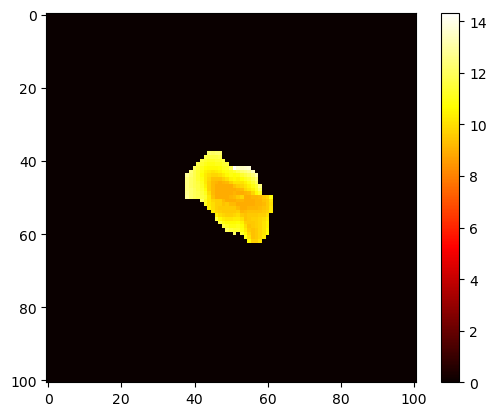

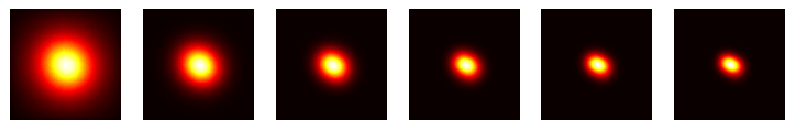

In [29]:
draw_img(sample_noTBR, type='depth', data_type='phantom')
draw_img(sample_noTBR, type='fluorescence', data_type='phantom')

/tmp/ipykernel_136531/1858424392.py:18: RuntimeWarning: invalid value encountered in divide
  smoothed = num / den


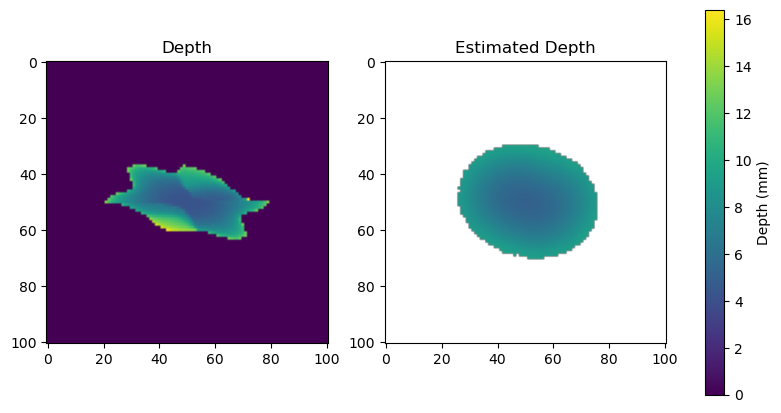

min_err: 0.895541757043734 at 5


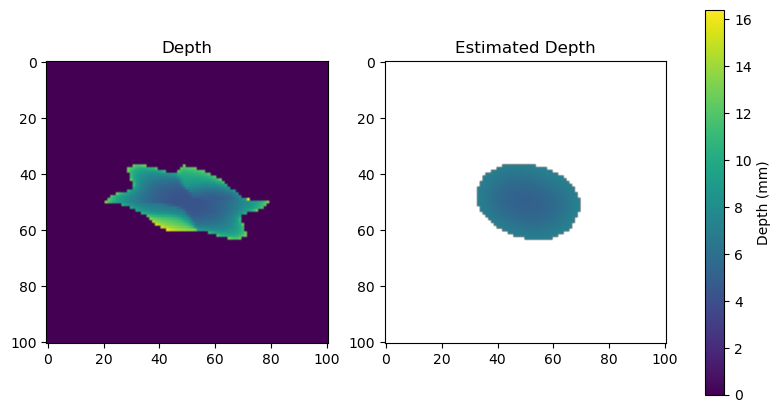

min_err: 1.5385549472807847 at 5


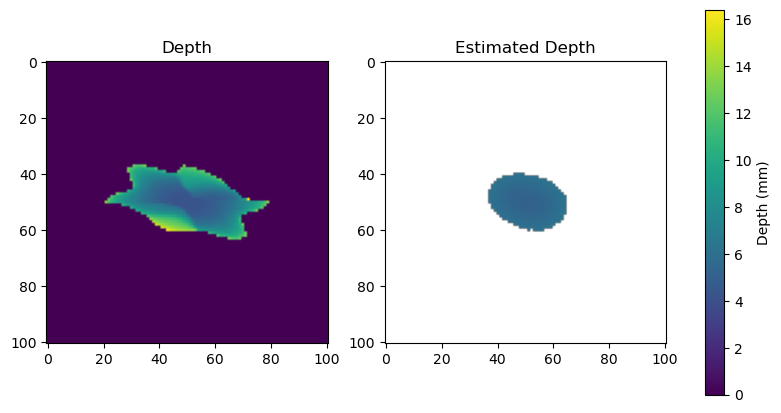

min_err: 1.403149647879698 at 5


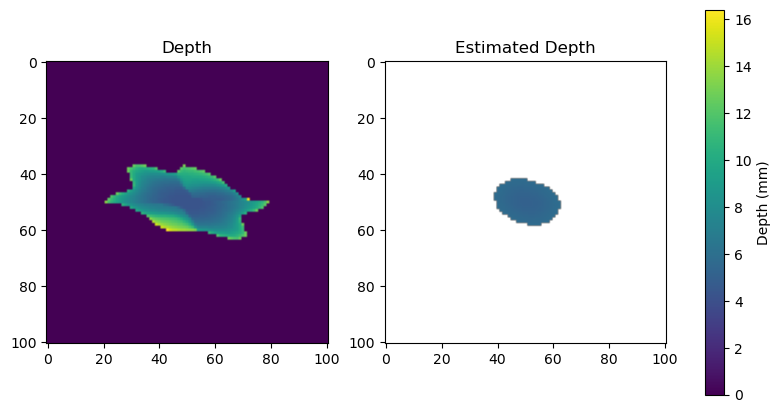

min_err: 1.1420557620607552 at 5


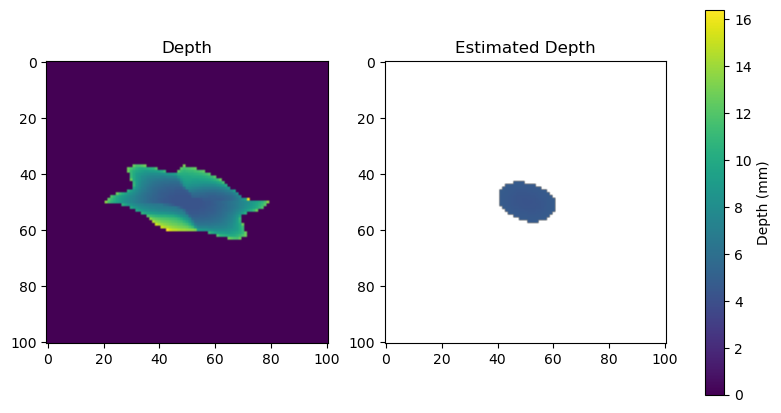

min_err: 0.8780399140827512 at 4


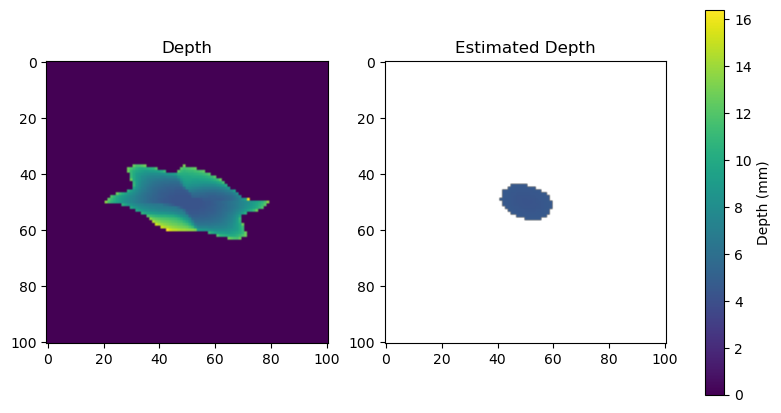

min_err: 0.7232255689126058 at 4


In [40]:
for base_idx in range(0, 6):
    idx = 11
    sample_noTBR = {
        'fluorescence': noTBR['fluorescence'][idx,...],
        'op': noTBR['optical_props'][idx,...],
        'depth': noTBR['depth'][idx,...],
        'concentration_fluor': noTBR['concentration_fluor'][idx,...],
        'reflectance': noTBR['reflectance'][idx,...]
    }
    region_mask, _ = compute_depth_inversion(test_data=sample_noTBR, idx=base_idx, base_idx=base_idx, draw=False)
    min_err = np.inf
    min_idx = 0
    for i in range(0, 6):
        _, err = compute_depth_inversion(test_data=sample_noTBR, idx=i, base_idx=base_idx, mask=region_mask, draw=False)
        if err < min_err:
            min_err = err
            min_idx = i
    compute_depth_inversion(test_data=sample_noTBR, idx=min_idx, base_idx=base_idx, mask=region_mask, draw=True)
    print(f"min_err: {min_err/np.sum(region_mask)} at {min_idx}")

# large deep

/tmp/ipykernel_892/1858424392.py:18: RuntimeWarning: invalid value encountered in divide
  smoothed = num / den


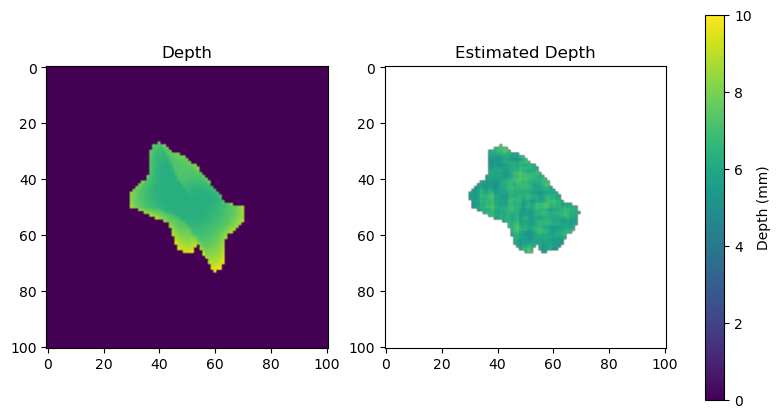

Minimum error: 1.0225 mm at index 5


In [31]:
kan_large_deep = read_mat_data('data/newKAN/2000_large_deep.mat')
sample_large_deep = {
    'fluorescence': kan_large_deep['fluorescence'][0,...],
    'op': kan_large_deep['op'][0,...],
    'depth': kan_large_deep['depth'][0,...],
    'concentration_fluor': kan_large_deep['concentration_fluor'][0,...],
    'reflectance': kan_large_deep['reflectance'][0,...]
}

region_mask, _ = compute_depth_inversion(sample_large_deep, 1, draw=False)
min_err = np.inf
min_idx = 0
for i in range(2, 6):
    _, err = compute_depth_inversion(sample_large_deep, i, region_mask, draw=False)
    if err < min_err:
        min_err = err
        min_idx = i
compute_depth_inversion(sample_large_deep, min_idx, region_mask, draw=True)

print(f"Minimum error: {min_err:.4f} mm at index {min_idx}")

# large sheep

/tmp/ipykernel_20229/1858424392.py:18: RuntimeWarning: invalid value encountered in divide
  smoothed = num / den


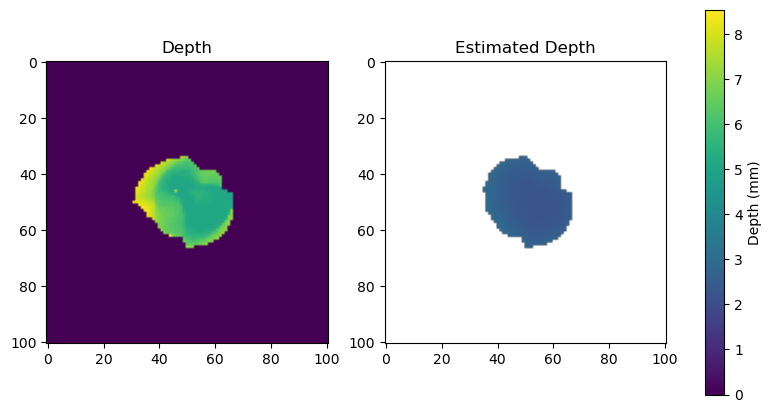

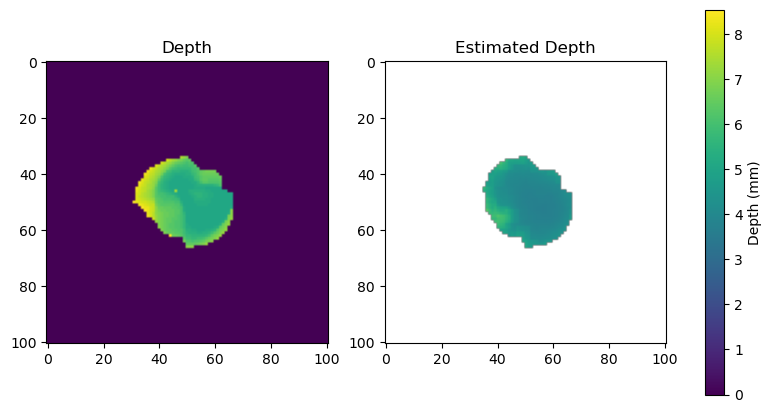

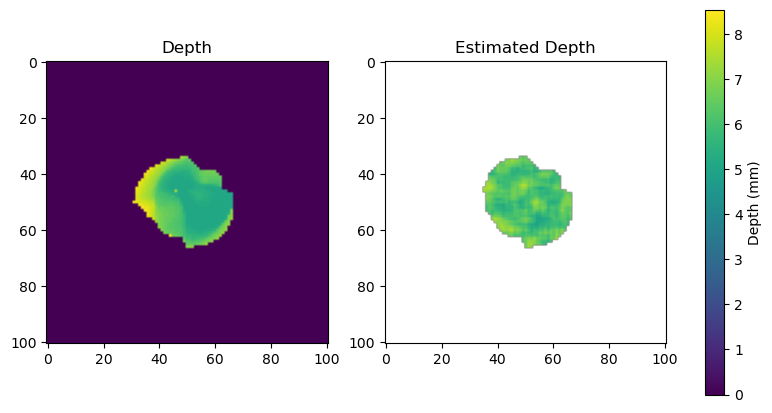

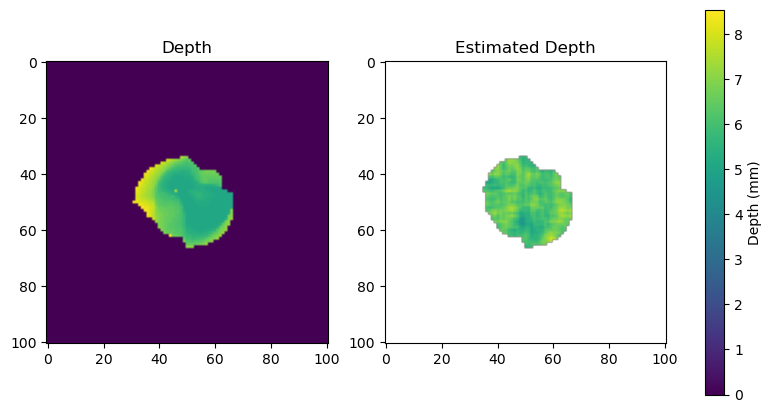

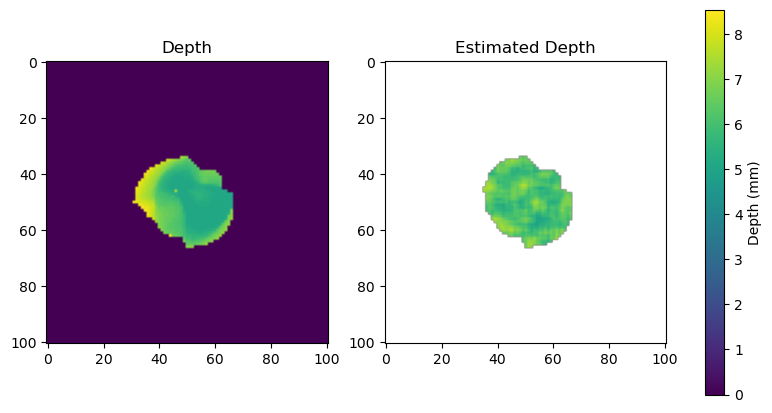

Minimum error: 0.7002 mm at index 4


In [196]:
kan_large_deep = read_mat_data('data/newKAN/2000_large_sheep.mat')
sample_large_deep = {
    'fluorescence': kan_large_deep['fluorescence'][0,...],
    'op': kan_large_deep['op'][0,...],
    'depth': kan_large_deep['depth'][0,...],
    'concentration_fluor': kan_large_deep['concentration_fluor'][0,...],
    'reflectance': kan_large_deep['reflectance'][0,...]
}

region_mask, _ = compute_depth_inversion(sample_large_deep, 1, draw=False)
min_err = np.inf
min_idx = 0
for i in range(2, 6):
    _, err = compute_depth_inversion(sample_large_deep, i, region_mask, draw=True)
    if err < min_err:
        min_err = err
        min_idx = i
compute_depth_inversion(sample_large_deep, min_idx, region_mask, draw=True)

print(f"Minimum error: {min_err:.4f} mm at index {min_idx}")

# large shallow

/tmp/ipykernel_20229/1858424392.py:18: RuntimeWarning: invalid value encountered in divide
  smoothed = num / den


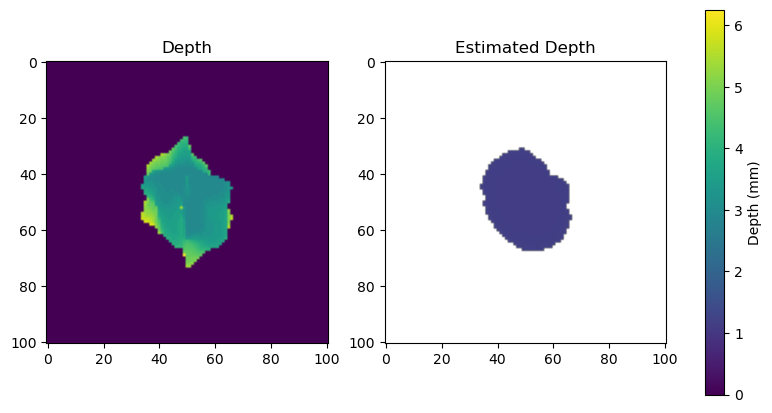

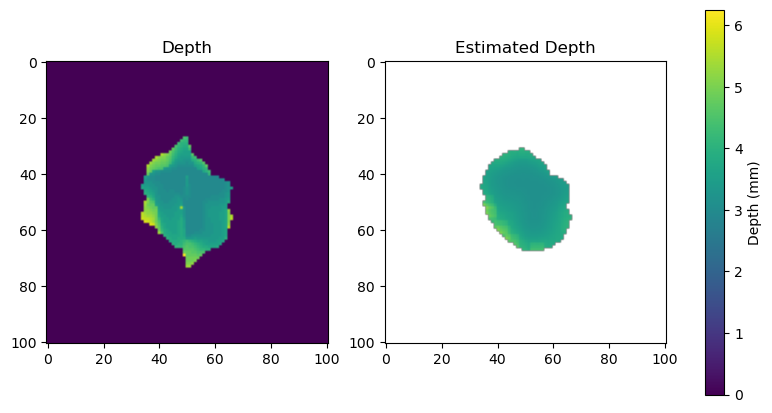

Minimum error: 0.3036 mm at index 5


In [195]:
kan_large_deep = read_mat_data('data/newKAN/2000_large_shallow.mat')
sample_large_deep = {
    'fluorescence': kan_large_deep['fluorescence'][0,...],
    'op': kan_large_deep['op'][0,...],
    'depth': kan_large_deep['depth'][0,...],
    'concentration_fluor': kan_large_deep['concentration_fluor'][0,...],
    'reflectance': kan_large_deep['reflectance'][0,...]
}

region_mask, _ = compute_depth_inversion(sample_large_deep, 1, draw=True)
min_err = np.inf
min_idx = 0
for i in range(2, 6):
    _, err = compute_depth_inversion(sample_large_deep, i, region_mask, draw=False)
    if err < min_err:
        min_err = err
        min_idx = i
compute_depth_inversion(sample_large_deep, min_idx, region_mask, draw=True)

print(f"Minimum error: {min_err:.4f} mm at index {min_idx}")

# medium deep

Mean error: 5.6772 mm


/tmp/ipykernel_20229/1858424392.py:18: RuntimeWarning: invalid value encountered in divide
  smoothed = num / den


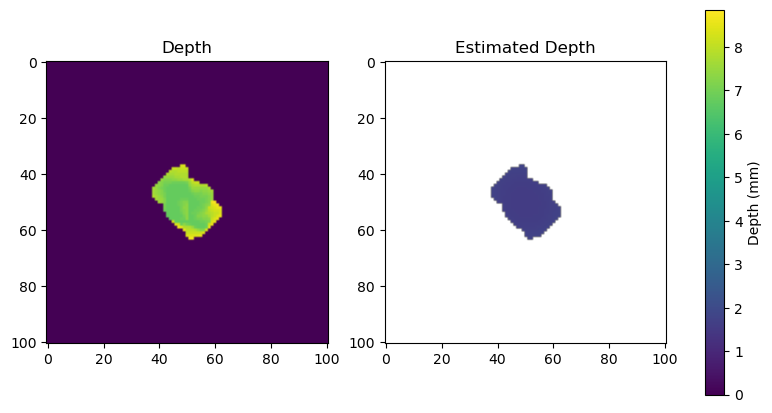

Mean error: 3.5704 mm
Mean error: 0.8229 mm
Mean error: 0.9554 mm
Mean error: 0.9136 mm
Minimum error: 0.8229 mm at index 3


In [186]:
kan_large_deep = read_mat_data('data/newKAN/2000_medium_deep.mat')
sample_large_deep = {
    'fluorescence': kan_large_deep['fluorescence'][0,...],
    'op': kan_large_deep['op'][0,...],
    'depth': kan_large_deep['depth'][0,...],
    'concentration_fluor': kan_large_deep['concentration_fluor'][0,...],
    'reflectance': kan_large_deep['reflectance'][0,...]
}

region_mask, _ = compute_depth_inversion(sample_large_deep, 1, draw=True)
min_err = np.inf
min_idx = 0
for i in range(2, 6):
    _, err = compute_depth_inversion(sample_large_deep, i, region_mask, draw=False)
    if err < min_err:
        min_err = err
        min_idx = i

print(f"Minimum error: {min_err:.4f} mm at index {min_idx}")

# medium sheep

Mean error: 4.5996 mm


/tmp/ipykernel_20229/1858424392.py:18: RuntimeWarning: invalid value encountered in divide
  smoothed = num / den


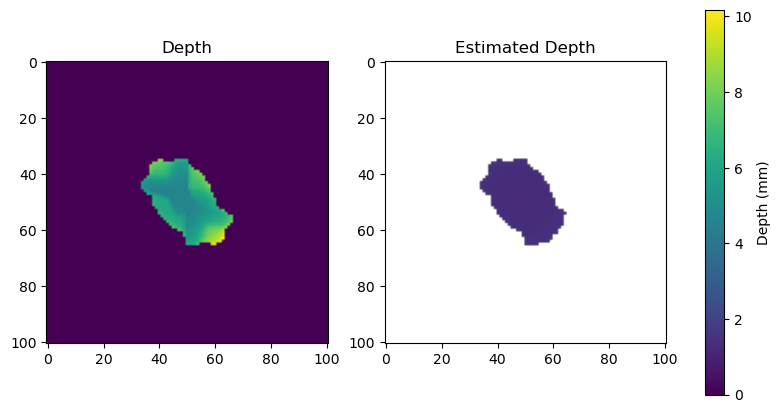

Mean error: 3.5357 mm
Mean error: 1.4595 mm
Mean error: 0.8871 mm
Mean error: 0.8542 mm
Minimum error: 0.8542 mm at index 5


In [185]:
kan_large_deep = read_mat_data('data/newKAN/2000_medium_sheep.mat')
sample_large_deep = {
    'fluorescence': kan_large_deep['fluorescence'][0,...],
    'op': kan_large_deep['op'][0,...],
    'depth': kan_large_deep['depth'][0,...],
    'concentration_fluor': kan_large_deep['concentration_fluor'][0,...],
    'reflectance': kan_large_deep['reflectance'][0,...]
}

region_mask, _ = compute_depth_inversion(sample_large_deep, 1, draw=True)
min_err = np.inf
min_idx = 0
for i in range(2, 6):
    _, err = compute_depth_inversion(sample_large_deep, i, region_mask, draw=False)
    if err < min_err:
        min_err = err
        min_idx = i

print(f"Minimum error: {min_err:.4f} mm at index {min_idx}")

# medium shallow

Mean error: 1.0484 mm


/tmp/ipykernel_20229/1858424392.py:18: RuntimeWarning: invalid value encountered in divide
  smoothed = num / den


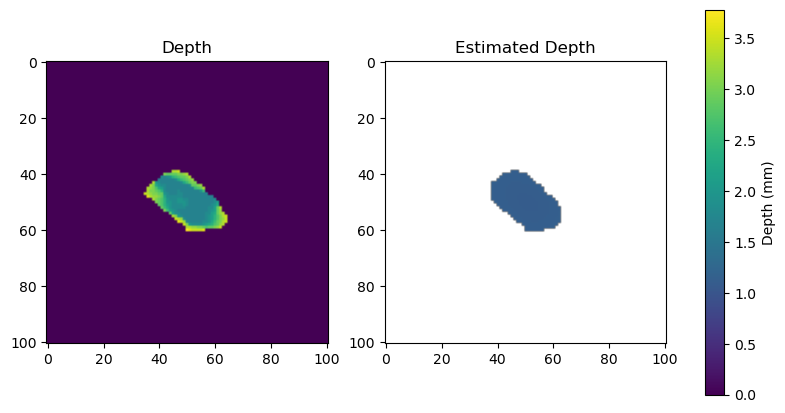

Mean error: 0.9194 mm
Mean error: 0.6771 mm
Mean error: 0.3985 mm
Mean error: 0.3755 mm
Minimum error: 0.3755 mm at index 5


In [184]:
kan_large_deep = read_mat_data('data/newKAN/2000_medium_shallow.mat')
sample_large_deep = {
    'fluorescence': kan_large_deep['fluorescence'][0,...],
    'op': kan_large_deep['op'][0,...],
    'depth': kan_large_deep['depth'][0,...],
    'concentration_fluor': kan_large_deep['concentration_fluor'][0,...],
    'reflectance': kan_large_deep['reflectance'][0,...]
}

region_mask, _ = compute_depth_inversion(sample_large_deep, 1, draw=True)
min_err = np.inf
min_idx = 0
for i in range(2, 6):
    _, err = compute_depth_inversion(sample_large_deep, i, region_mask, draw=False)
    if err < min_err:
        min_err = err
        min_idx = i

print(f"Minimum error: {min_err:.4f} mm at index {min_idx}")

# small deep

Mean error: 5.7447 mm


/tmp/ipykernel_20229/1858424392.py:18: RuntimeWarning: invalid value encountered in divide
  smoothed = num / den


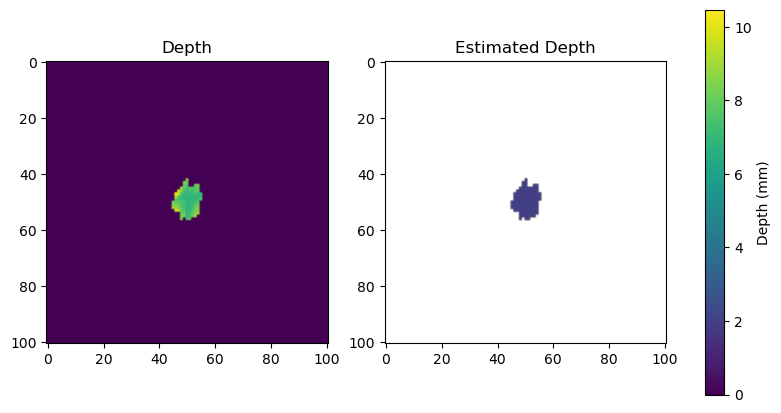

Mean error: 3.2529 mm
Mean error: 1.0384 mm
Mean error: 1.3277 mm
Mean error: 1.8973 mm
Minimum error: 1.0384 mm at index 3


In [183]:
kan_large_deep = read_mat_data('data/newKAN/2000_small_deep.mat')
sample_large_deep = {
    'fluorescence': kan_large_deep['fluorescence'][0,...],
    'op': kan_large_deep['op'][0,...],
    'depth': kan_large_deep['depth'][0,...],
    'concentration_fluor': kan_large_deep['concentration_fluor'][0,...],
    'reflectance': kan_large_deep['reflectance'][0,...]
}

region_mask, _ = compute_depth_inversion(sample_large_deep, 1, draw=True)
min_err = np.inf
min_idx = 0
for i in range(2, 6):
    _, err = compute_depth_inversion(sample_large_deep, i, region_mask, draw=False)
    if err < min_err:
        min_err = err
        min_idx = i

print(f"Minimum error: {min_err:.4f} mm at index {min_idx}")

# small sheep

Mean error: 3.5719 mm


/tmp/ipykernel_20229/1858424392.py:18: RuntimeWarning: invalid value encountered in divide
  smoothed = num / den


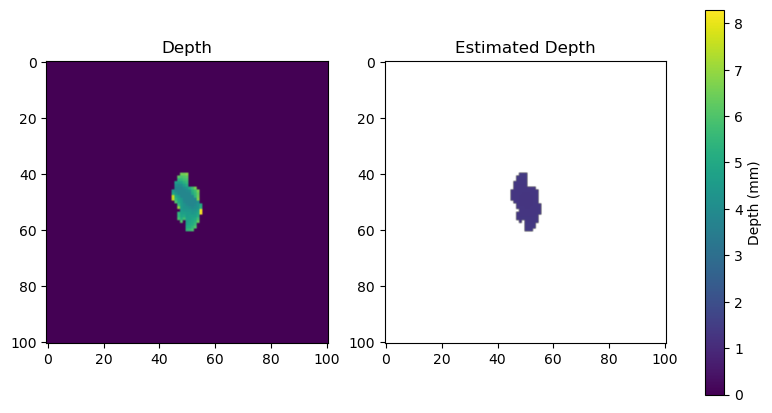

Mean error: 2.7903 mm
Mean error: 1.6136 mm
Mean error: 0.7730 mm
Mean error: 1.1786 mm
Minimum error: 0.7730 mm at index 4


In [182]:
kan_large_deep = read_mat_data('data/newKAN/2000_small_sheep.mat')
sample_large_deep = {
    'fluorescence': kan_large_deep['fluorescence'][0,...],
    'op': kan_large_deep['op'][0,...],
    'depth': kan_large_deep['depth'][0,...],
    'concentration_fluor': kan_large_deep['concentration_fluor'][0,...],
    'reflectance': kan_large_deep['reflectance'][0,...]
}

region_mask, _ = compute_depth_inversion(sample_large_deep, 1, draw=True)
min_err = np.inf
min_idx = 0
for i in range(2, 6):
    _, err = compute_depth_inversion(sample_large_deep, i, region_mask, draw=False)
    if err < min_err:
        min_err = err
        min_idx = i

print(f"Minimum error: {min_err:.4f} mm at index {min_idx}")

# small shallow

Mean error: 1.0858 mm


/tmp/ipykernel_20229/1858424392.py:18: RuntimeWarning: invalid value encountered in divide
  smoothed = num / den


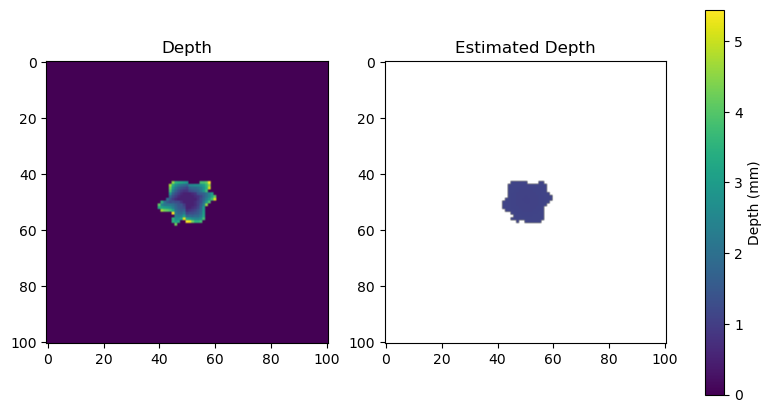

Mean error: 1.0372 mm
Mean error: 0.9502 mm
Mean error: 0.8605 mm
Mean error: 0.7877 mm
Minimum error: 0.7877 mm at index 5


In [181]:
kan_large_deep = read_mat_data('data/newKAN/2000_small_shallow.mat')
sample_large_deep = {
    'fluorescence': kan_large_deep['fluorescence'][0,...],
    'op': kan_large_deep['op'][0,...],
    'depth': kan_large_deep['depth'][0,...],
    'concentration_fluor': kan_large_deep['concentration_fluor'][0,...],
    'reflectance': kan_large_deep['reflectance'][0,...]
}

region_mask, _ = compute_depth_inversion(sample_large_deep, 1, draw=True)
min_err = np.inf
min_idx = 0
for i in range(2, 6):
    _, err = compute_depth_inversion(sample_large_deep, i, region_mask, draw=False)
    if err < min_err:
        min_err = err
        min_idx = i

print(f"Minimum error: {min_err:.4f} mm at index {min_idx}")

Mean error: 3.7550 mm


/tmp/ipykernel_20229/1858424392.py:18: RuntimeWarning: invalid value encountered in divide
  smoothed = num / den


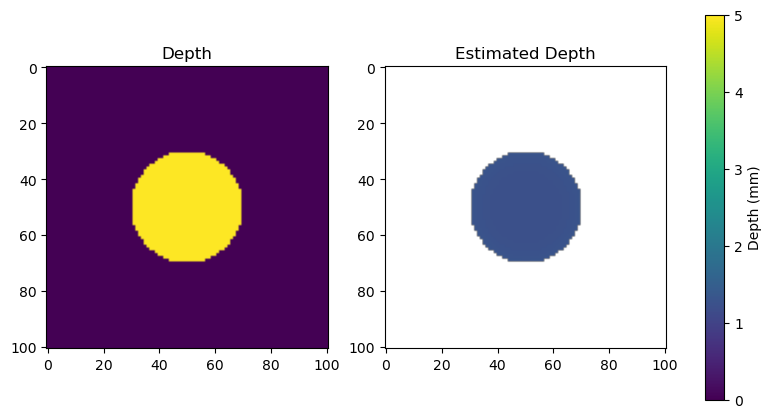

Mean error: 2.8878 mm


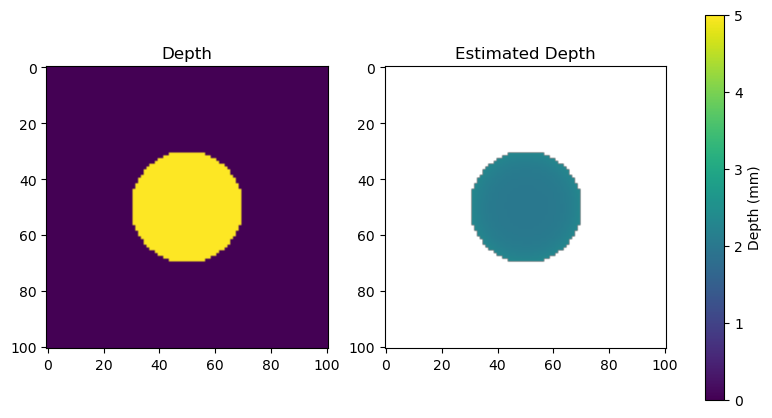

Mean error: 1.4084 mm


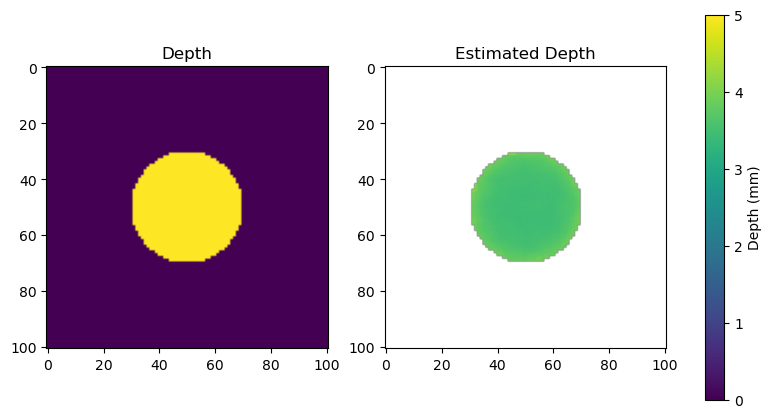

Mean error: 0.7291 mm


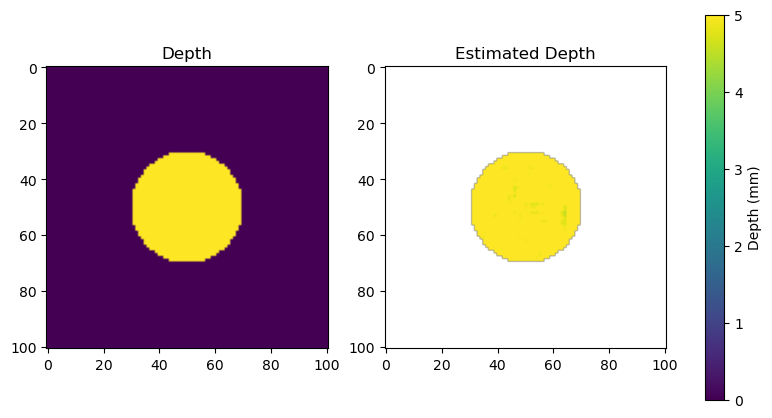

Mean error: 1.2639 mm


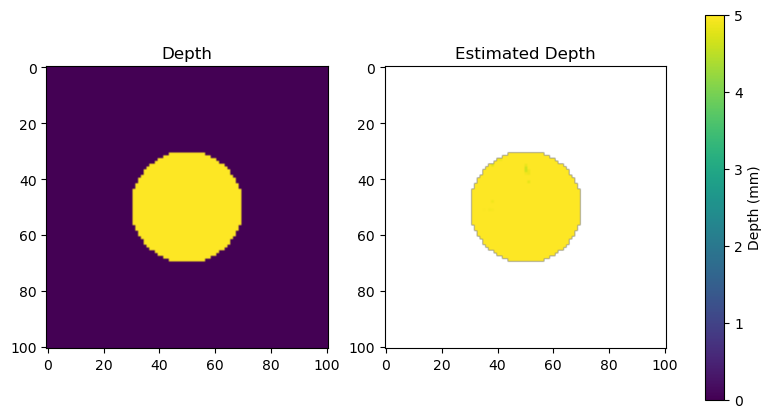

In [171]:
test_data_path = 'data/cylinder/h3_r10_d5.mat'
test_data = read_mat_data(test_data_path)
region_mask = compute_depth_inversion(test_data, 1)
# compute_depth_inversion(test_data, 5, region_mask)
for i in range(2, 6):
    compute_depth_inversion(test_data, i, region_mask)

In [ ]:
draw_img(test_data, type='fluorescence', data_type='cylinder')

draw_img(test_data, type='depth', data_type='cylinder')